In [27]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from scipy.signal import find_peaks, peak_widths
import astropy.units as u
import numpy as np
import pandas as pd
import math
from collections import defaultdict
from astropy.table import QTable, Table, Column

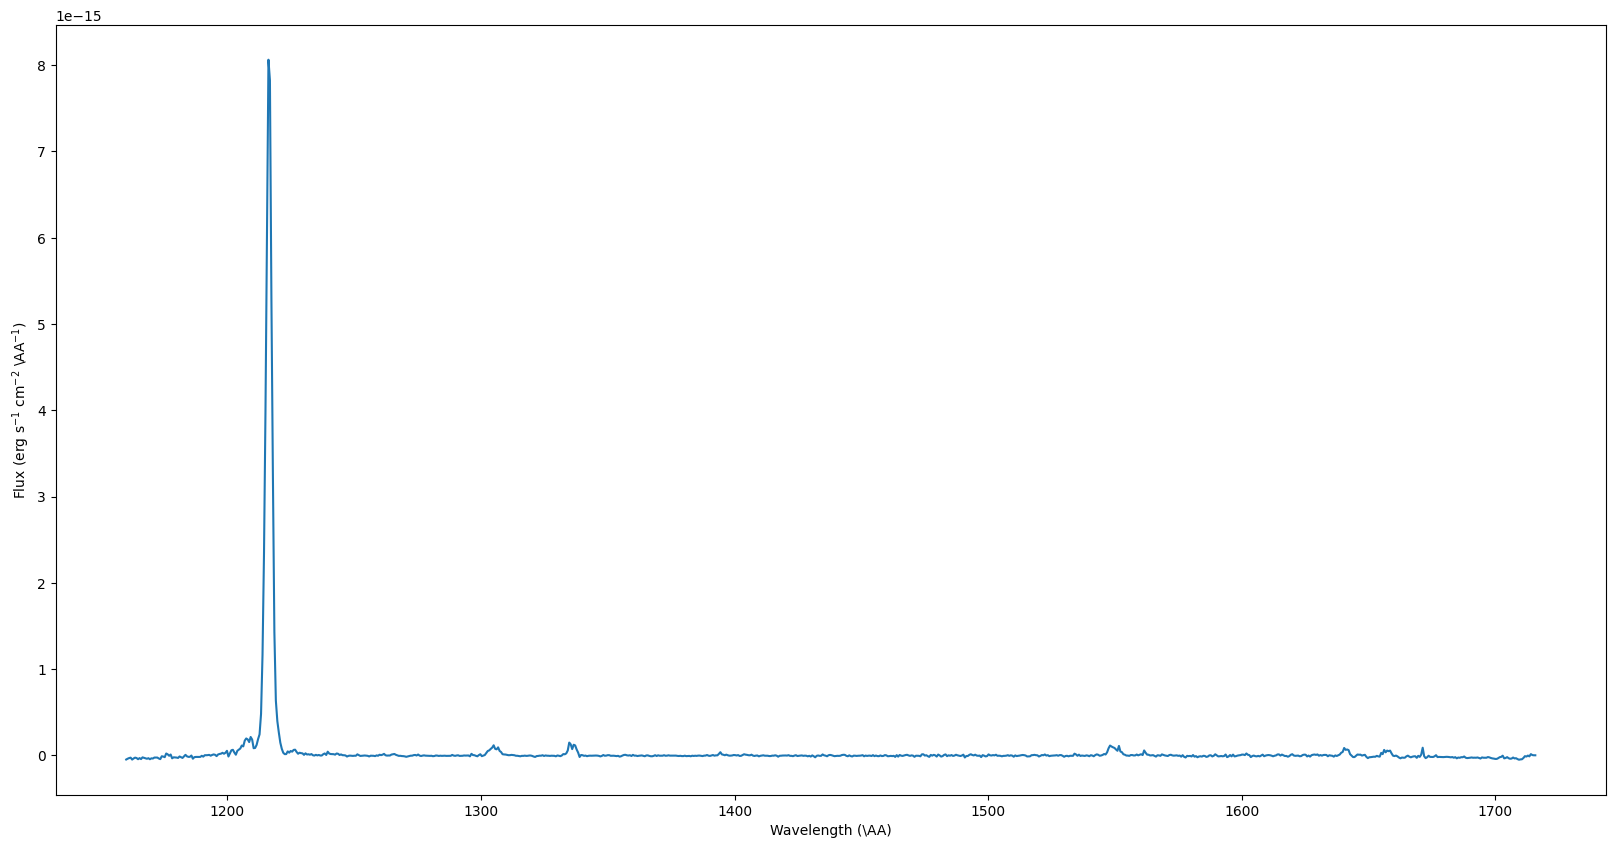

In [28]:
data = fits.getdata('hlsp_muscles_hst_stis_toi-776_g140l_v1_component-spec.fits')
w, f , e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
mask = (w > 1160) 
plt.figure(figsize=(20,10))

plt.plot(w[mask], f[mask])


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

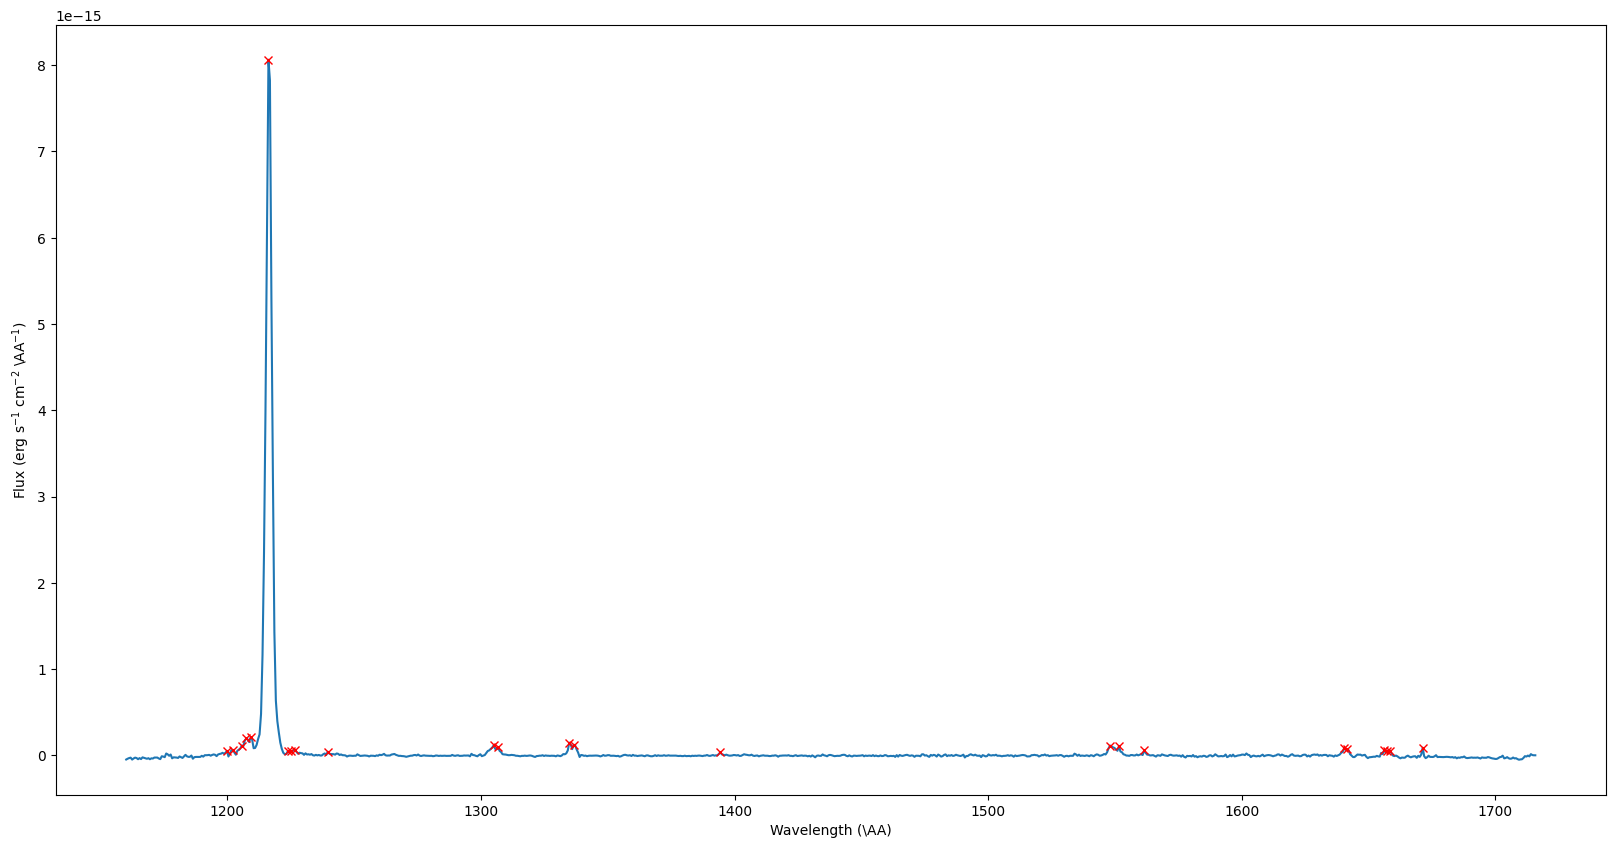

Peak 0: 1199.838781955976
Peak 1: 1202.1757796256882
Peak 2: 1205.6812761302565
Peak 3: 1207.4340243825407
Peak 4: 1209.1867726348248
Peak 5: 1216.1977656439615
Peak 6: 1223.7930080705262
Peak 7: 1224.9615069053823
Peak 8: 1226.7142551576665
Peak 9: 1239.5677423410837
Peak 10: 1305.0036770930258
Peak 11: 1306.75642534531
Peak 12: 1334.8003973818566
Peak 13: 1336.5531456341407
Peak 14: 1394.3938379595181
Peak 15: 1548.0514347430965
Peak 16: 1551.5569312476648
Peak 17: 1561.4891713439417
Peak 18: 1640.362842696729
Peak 19: 1641.5313415315852
Peak 20: 1656.1375769672866
Peak 21: 1657.3060758021427
Peak 22: 1658.4745746369988
Peak 23: 1671.328061820416


In [29]:
# Find peaks
peaks, properties = find_peaks(f[mask], height = 0.7*sum(f[mask])/len(f[mask]),  width = 0)

plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask])
plt.plot(w[mask][peaks], f[mask][peaks], "xr")
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

# All peaks!
count = 0
for peak in w[mask][peaks]:
    print(f"Peak {count}: {peak}")
    count+=1

In [30]:
# Get rest data
data = pd.read_csv("../DEM_goodlinelist .csv")
df = pd.DataFrame(data)
# df = df[df["Likelihood to measure"] == "High"]
print(df)


# only use high liklihood of measurements! (do the filtering in the parsing in the actual flux calculations)

       Ion  Wavelength Likelihood to measure  Log Formation Temperature
0     S VI     933.397                Medium                        5.3
1    N III     989.787                Medium                        4.9
2    N III     991.495                Medium                        4.9
3    N III     991.564                Medium                        4.9
4    Ne VI     999.182                Medium                        5.6
5     O VI    1032.914                Medium                        5.5
6     O VI    1037.615                Medium                        5.5
7   Fe XIX    1118.057                   Low                        6.9
8     Ne V    1145.596                Medium                        5.5
9    C III    1174.935                  High                        4.9
10   C III    1175.265                  High                        4.9
11   C III    1175.592                  High                        4.9
12   C III    1175.713                  High                    

(-1e-16, 7.5e-16)

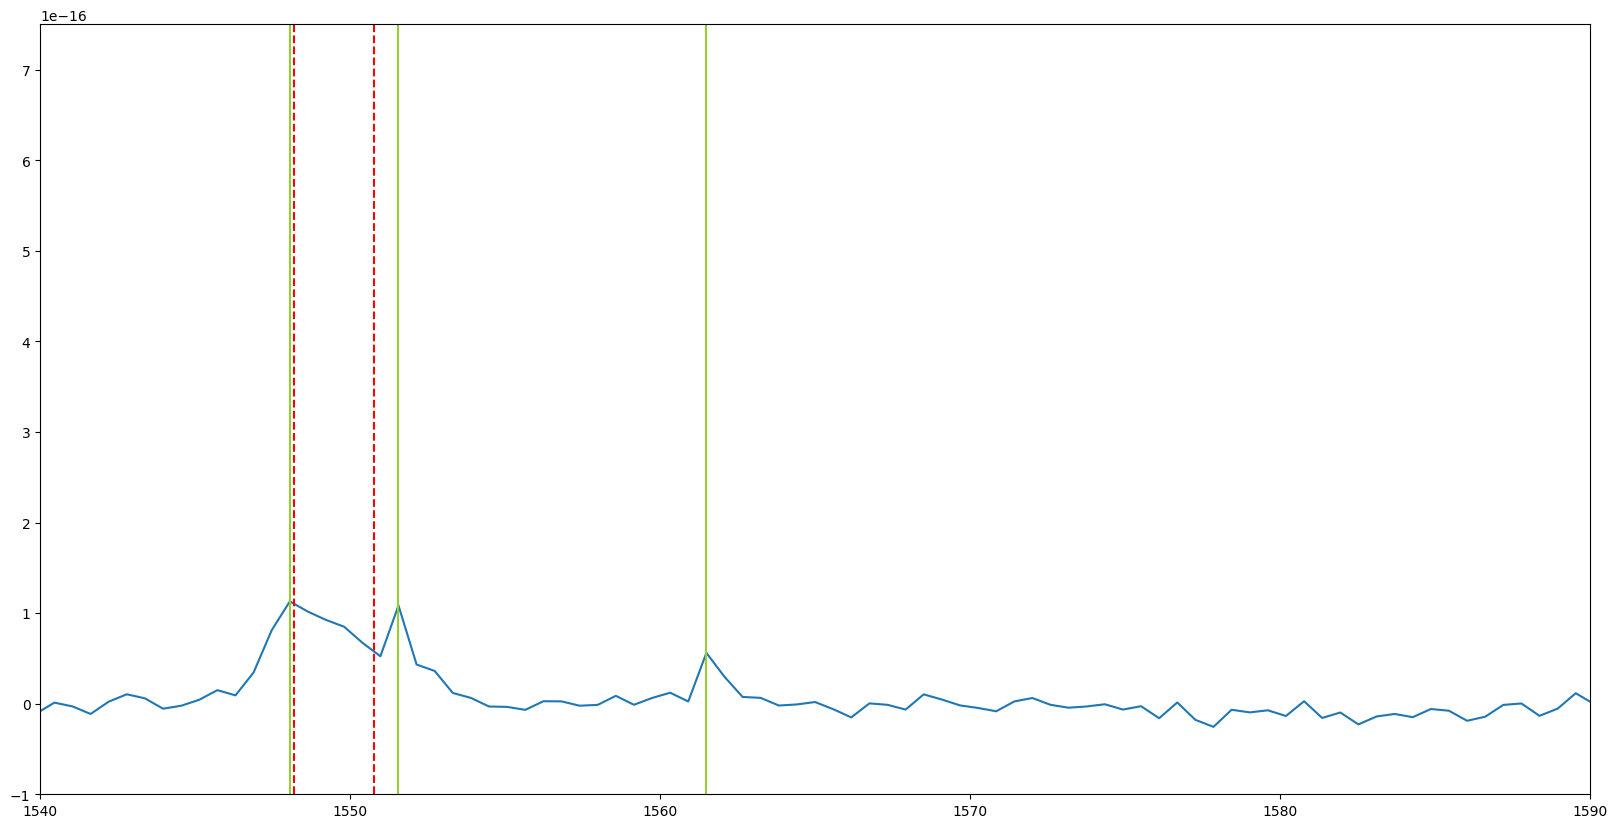

In [50]:
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 
count = 0

for line in df['Wavelength']:
    if(line > 1160) and (df['Likelihood to measure'][count] == "High"):
        plt.axvline(x = line, color = 'red', label = 'axvline - full height', linestyle = "--")
    count+=1
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')

plt.xlim([1540, 1590]) # add +50
plt.ylim([-0.1e-15, 0.75e-15])

<h5>Observed and rest wavelengths </h5>
1334.8003973818566		1334.524 (blended)

1336.5531456341407      1335.709 (blended)

1548.0514347430965      1548.201 (blended)

1551.5569312476648		1550.772 (blended)
<!-- 1336.7453071795508 1335.709

1394.95524368089 1393.755

1403.6867341560908 1402.770 -->



In [52]:
rest_lam = [1334.524, 1335.709, 1548.201, 1550.772]
obs_lam = [1334.8003973818566, 1336.5531456341407, 1548.0514347430965, 1551.5569312476648]

assert len(rest_lam)==len(obs_lam)

In [54]:
dv = []

# Combine the first two since they are close!
for i in range(0, len(rest_lam)):
    u_rest_lam = rest_lam[i] * u.AA
    u_obs_lam = obs_lam[i] * u.AA
    dv.append(u_obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(u_rest_lam)))

print(dv)

# Blended lines
dv[0] = (dv[0] + dv[1])/2
dv[1] = (dv[2] + dv[3])/2
del dv[-2:]


dv_average = sum(dv)/(len(dv))
print(f"Avg Doppler Shift: {dv_average}")

[<Quantity 62.09094066 km / s>, <Quantity 189.46379381 km / s>, <Quantity -28.961702 km / s>, <Quantity 151.74149914 km / s>]
Avg Doppler Shift: 93.58363290169132 km / s


Current peak estimate: 3.111535870374538
Peak width: 3.5
Flux range: 7.0
Angstroms_to_pixels: 0.5842494174280546
Peak width in pixels: 5


(-1e-16, 7.5e-16)

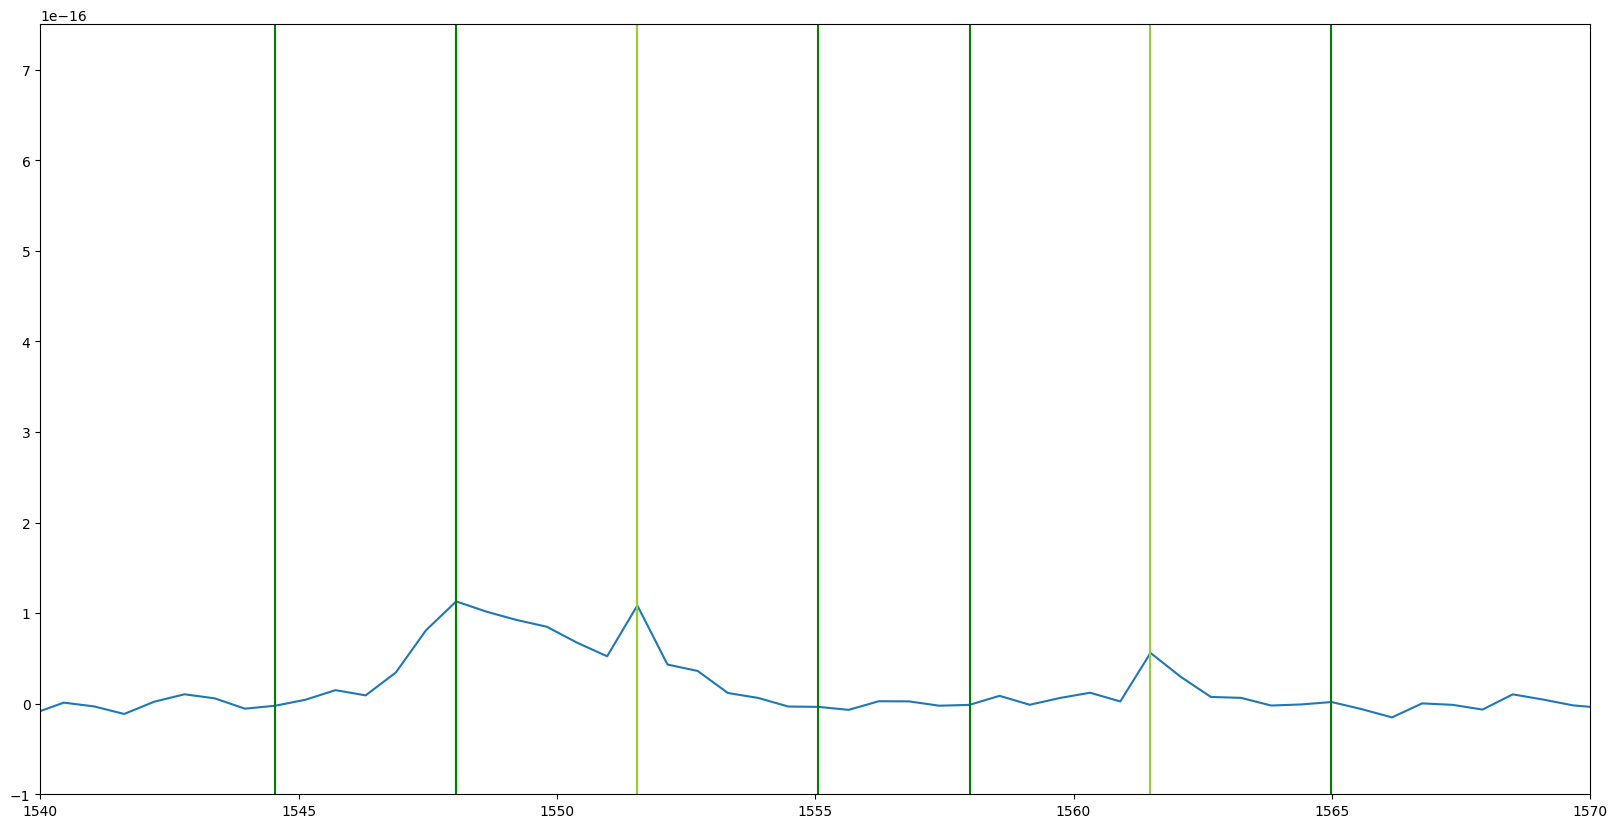

In [57]:
"""
    Peak width finder: first make a guesstimate using peak properties, then refine later
"""
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

# Make estimate
avg_peak_width = (sum(properties['widths'])/len(properties['widths']))
print(f"Current peak estimate: {avg_peak_width}")

# Refine based on estimated
peak_width = 3.5
print(f"Peak width: {peak_width}")

# Make range 
flux_range = 2*peak_width
print(f"Flux range: {flux_range}")

# Flux range in pixels
angstroms_to_pixels = w[1] - w[0] # NOTE! have to recalculate this number every time
print(f"Angstroms_to_pixels: {angstroms_to_pixels}")
peak_width_pixels = math.floor(peak_width/angstroms_to_pixels)
print(f"Peak width in pixels: {peak_width_pixels}")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')
    plt.axvline(x = peak + peak_width, color = 'green', label = 'axvline - full height')
    plt.axvline(x = peak - peak_width, color = 'green', label = 'axvline - full height')

plt.xlim([1540, 1570]) # add +60
plt.ylim([-0.1e-15, 0.75e-15])

In [35]:
def wavelength_edges(w):
    """
    Calulates w0 and w1(boxes to be used to calculate the flux)
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

In [36]:
"""
    Make a trendline based on the average flux within the mask from the left and right to the peak 
    (use if there is a lot of noise)
"""
def create_trendline(w, f, blended_line_bool):
    # Initialize variables
    length = len(w) - 1
    flux_list = []
    
    # Make an array of all flux that aren't included in the peak
    for i in range(0, peak_width_pixels):
        flux_list.append(f[i])
        flux_list.append(f[length-i])
        
    # Find the average flux 
    avg_flux = sum(flux_list)/len(flux_list)
    flux_array = [avg_flux for i in range(length + 1)]
           
    wavelength_array = np.array(w)
    
    z = np.polyfit(w, flux_array, 1)
    p = np.poly1d(z)
    
    if blended_line_bool == True:
        plt.plot(wavelength_array, p(wavelength_array), color="blue", alpha=0.6)
    else:
        plt.plot(wavelength_array, p(wavelength_array), color="red", alpha=0.6)
    
    return p(wavelength_array) 

In [37]:
"""
    Make a trendline based on the average flux within the mask, without the peak
"""
def split_create_trendline(w, f, blended_line_bool):
    # Initialize variables
    length = len(w) - 1
    flux_list_left = []
    flux_list_right = []
    
    # Make an array of all flux that aren't included in the peak
    for i in range(0, peak_width_pixels):
        flux_list_left.append(f[i])
        flux_list_right.append(f[length-i])
        
    # Find the average flux for the left and right
    avg_flux_left = sum(flux_list_left)/len(flux_list_left)
    avg_flux_right = sum(flux_list_right)/len(flux_list_right)
    
    # Use the lesser of the two values as the average flux
    if avg_flux_left < avg_flux_right:
        avg_flux = avg_flux_left
    else:
        avg_flux = avg_flux_right
    
    flux_array = [avg_flux for i in range(length + 1)]
           
    wavelength_array = np.array(w)
    
    z = np.polyfit(w, flux_array, 1)
    p = np.poly1d(z)
    
    if blended_line_bool == True:
        plt.plot(wavelength_array, p(wavelength_array), color="blue", alpha=0.6)
    else:
        plt.plot(wavelength_array, p(wavelength_array), color="red", alpha=0.6)
    
    return p(wavelength_array) 

Flux: 1.9012566370602927e-16
Error: 3.558440885936686e-17


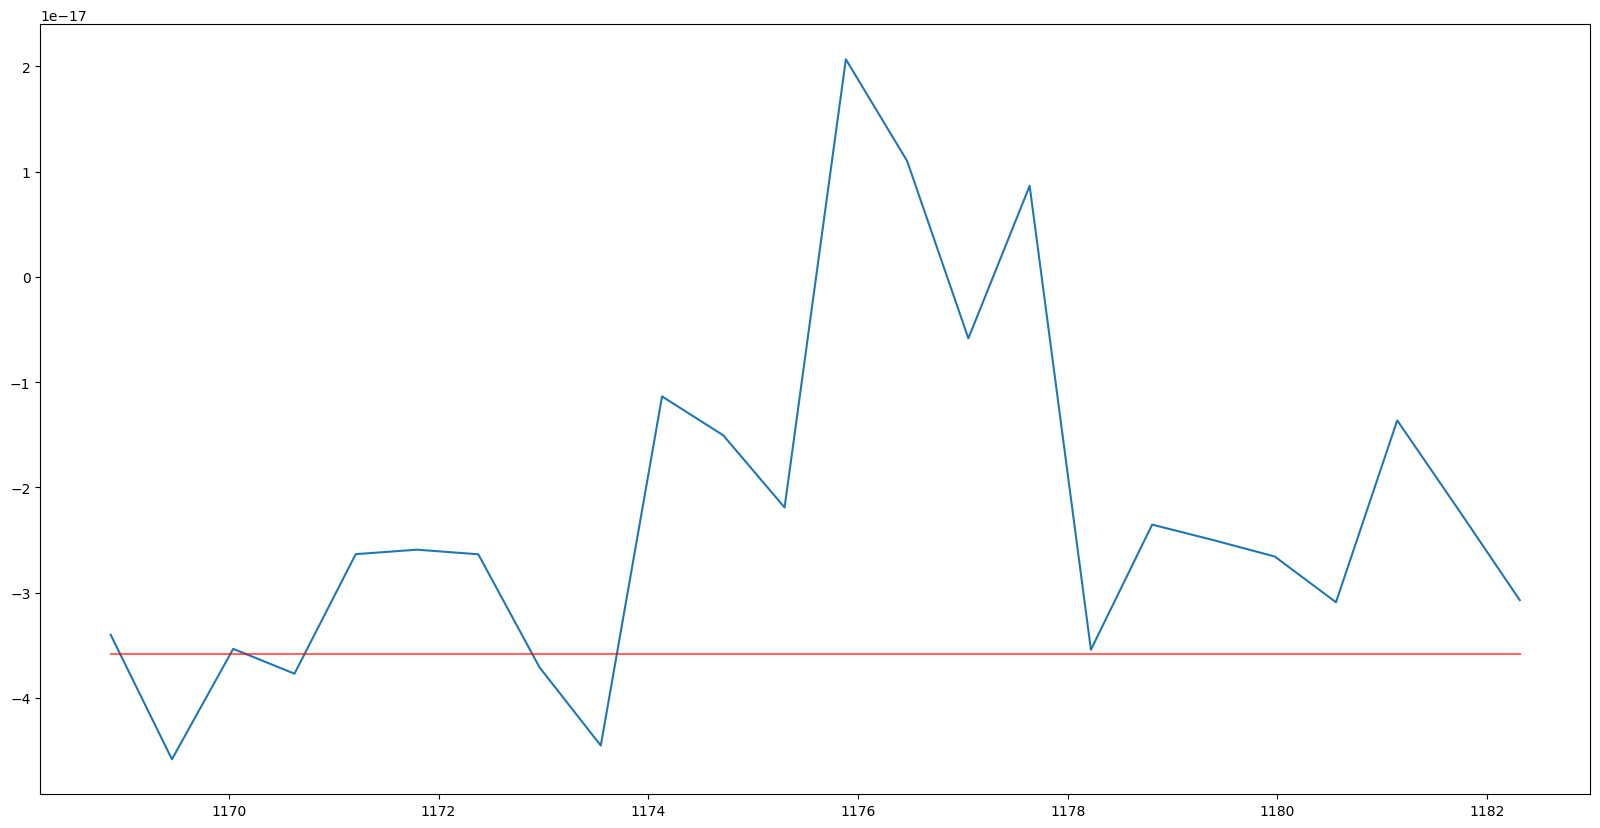

In [38]:
# Mask current peak (use this for the rest!)
wavelength_mask = (w > 1168.289313414861) & (w <  1182.8955488505624)
w0,w1 = wavelength_edges(w[wavelength_mask])
total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5

plt.figure(figsize=(20,10))
plt.plot(w[wavelength_mask], f[wavelength_mask])


# Continuum calculation
continuum = []
trendline = split_create_trendline(w[wavelength_mask], f[wavelength_mask], False) 

for i in range(0, len(trendline)):
    continuum.append(trendline[i])

continuum_sumflux = np.sum(continuum*(w1-w0))


print(f"Flux: {total_sumflux - continuum_sumflux}")
print(f"Error: {sumerror}")


In [39]:
def check_in_range(val1, val2, x):
    if val1 <= x <= val2:
        return True
    else:
        return False

In [40]:
"""
    Checks if there is a blended line by seeing if the previous peak is within the current obs_lam's range
"""
def blended_line_check(previous_obs, obs_lam, iterations):
    if check_in_range(obs_lam.value - flux_range, obs_lam.value + flux_range, previous_obs.value) and (iterations != 0):
        return True
    else:
        return False

Ion: C III 
('Wavelength: 1176.372', 'Flux: 2.2691930455609014e-16', 'Error: 3.65518141339874e-17', 'Blended line: True')
Ion: Si III 
('Wavelength: 1206.499', 'Flux: 1.9030638613381423e-15', 'Error: 1.8211329481007677e-16', 'Blended line: False')
Ion: N V 
('Wavelength: 1242.804', 'Flux: 2.052413896935092e-16', 'Error: 2.0350479899910956e-17', 'Blended line: True')
Ion: Si II 
('Wavelength: 1264.737', 'Flux: 1.5099906408115512e-16', 'Error: 1.1403014437812306e-17', 'Blended line: False')
('Wavelength: 1304.369', 'Flux: 4.906900429349936e-16', 'Error: 4.819644491273275e-17', 'Blended line: True')
Ion: C II 
('Wavelength: 1323.952', 'Flux: -3.8695910554532635e-17', 'Error: 0', 'Blended line: False')
('Wavelength: 1335.709', 'Flux: 5.032749353912823e-16', 'Error: 5.390798639760014e-17', 'Blended line: True')
Ion: Si IV 
('Wavelength: 1393.755', 'Flux: 7.318229906616864e-17', 'Error: 1.9023280470084173e-17', 'Blended line: False')
('Wavelength: 1402.77', 'Flux: 8.366078303756221e-17', 'Er

(-1e-16, 7.5e-16)

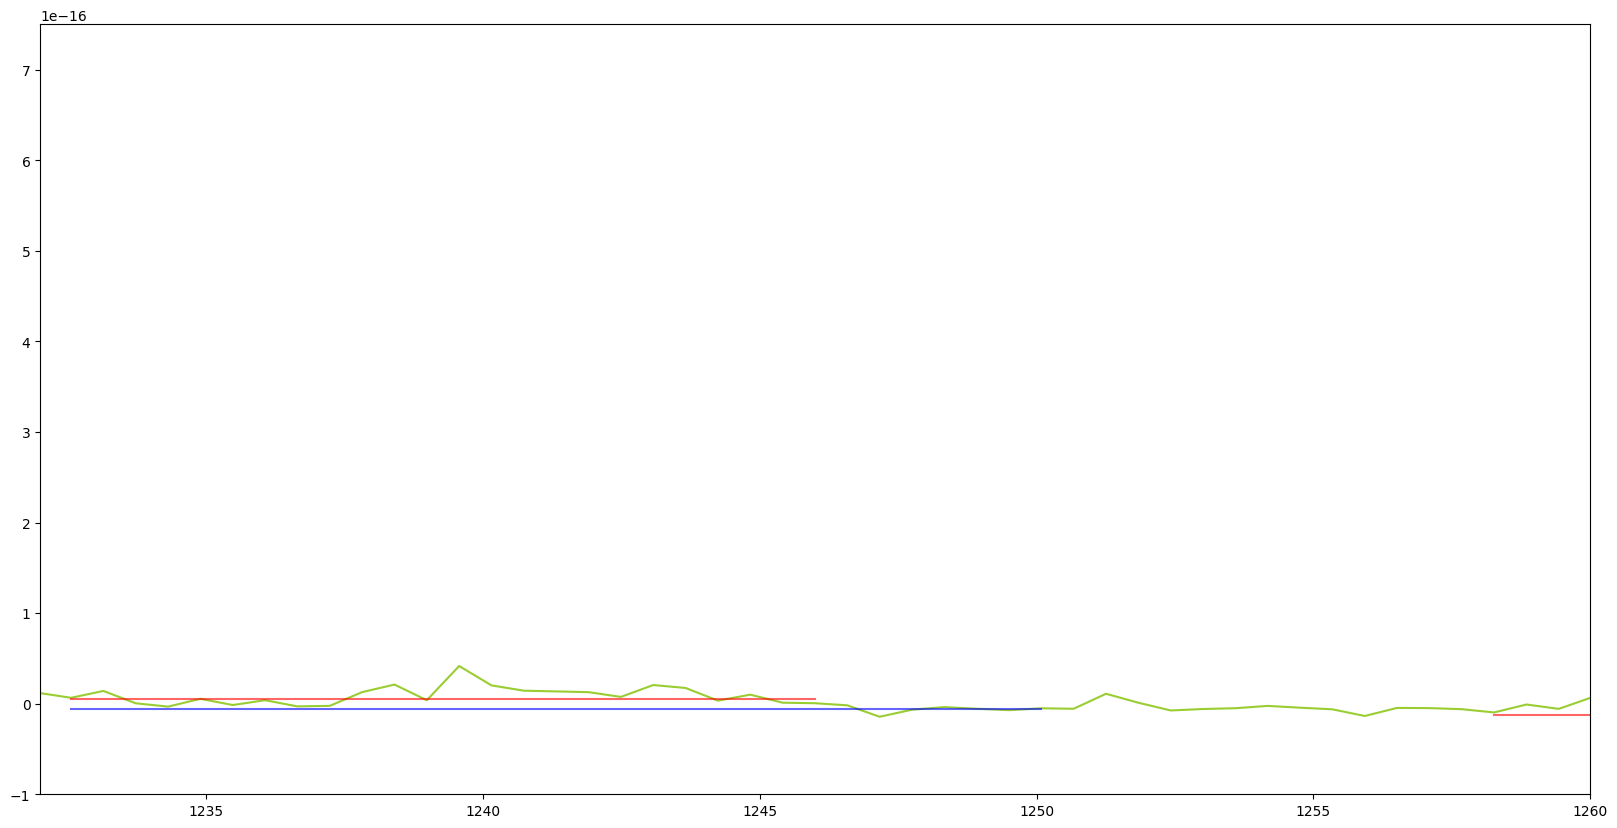

In [63]:
plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask], color="yellowgreen")

# Initializing
flux = defaultdict(list)
count = 0 
iterations = 0
previous_obs = 0 *u.AA
prev_blended_bool = False
prev_left_bound = 0

for wavelength in df["Wavelength"]:
    if((wavelength > 1160) and df['Likelihood to measure'][count] == "High") or wavelength == 1640.420:     
        continuum = []
        
        # Calculate the obs_lam
        rest_lam = wavelength * u.AA
        obs_lam = dv_average.to(u.AA,  equivalencies=u.doppler_optical(rest_lam))
        
        # Check for blended lines
        blended_line_bool = blended_line_check(previous_obs, obs_lam, iterations)
        # Check if previous lam was also a blended line
        if blended_line_bool and prev_blended_bool:
            wavelength_mask = (w > prev_left_bound) & (w <= (obs_lam.value + flux_range))
            prev_blended_bool = True
        # If there is a blended line, and previous wasn't a blended line
        elif blended_line_bool:
            wavelength_mask = (w > (previous_obs.value - flux_range)) & (w <= (obs_lam.value + flux_range))
            prev_blended_bool = True
            prev_left_bound = previous_obs.value - flux_range
        # Not a blended line
        else:
            wavelength_mask = (w > (obs_lam.value - flux_range)) & (w <= (obs_lam.value + flux_range))
            prev_blended_bool = False
        
        # Compute the flux and error
        w0,w1 = wavelength_edges(w[wavelength_mask])
        total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
        sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5
        
        # Create trendline
        trendline = split_create_trendline(w[wavelength_mask], f[wavelength_mask], blended_line_bool)

        # Calculate the continuum
        for i in range(0, len(trendline)):
            continuum.append(trendline[i])
        continuum_sumflux = np.sum(continuum*(w1-w0))
        
        # Check if the flux is negative
        total_flux = total_sumflux - continuum_sumflux
        if total_flux <= 3*sumerror: # check if flux is less than some upper limit
            # Make flux 3 * error, and have error be 0
            total_flux = sumerror * (-3)
            sumerror = 0
        
        # If there is a blended line
        if blended_line_bool:
            # Delete the previous flux calculation (check me!) - may need to get rid of [count-1]
            del flux[df['Ion'][count-1]][previous_index]
            # Add the new flux calculation
            flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_flux), "Error: " + str(sumerror), "Blended line: " + str(blended_line_bool)))
        # If there is not a blended line
        else:
            flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_flux), "Error: " + str(sumerror),"Blended line: " + str(False)))
            
        # Update variables
        previous_obs = obs_lam
        previous_index = len(flux[df['Ion'][count]]) - 1
        iterations+=1

        # print(f"Left Bound: {w[wavelength_mask][0]}, Right Bound: {w[wavelength_mask][len(w[wavelength_mask])-1]}")
        
    count+=1 
    
# Printing
for ion in flux:
    print(f"Ion: {ion} ")
    for data in flux[ion]:
        print(data)

plt.xlim([1232, 1260]) # add +60
plt.ylim([-0.1e-15, 0.75e-15])

In [42]:
# Astropy tables
data_array = []

for ion in flux:
    for data in flux[ion]:
        data_array.append({"Ion": ion, "Wavelength": data[0], "Flux": data[1], "Error": data[2], "Blended line": data[3]})

t = Table(rows=data_array)
print(t)
t.write('toi-776.ecsv', overwrite= True) #can do overwrite = true if changing flux calc

 Ion        Wavelength      ...     Blended line   
------ -------------------- ... -------------------
 C III Wavelength: 1176.372 ...  Blended line: True
Si III Wavelength: 1206.499 ... Blended line: False
   N V Wavelength: 1242.804 ...  Blended line: True
 Si II Wavelength: 1264.737 ... Blended line: False
 Si II Wavelength: 1304.369 ...  Blended line: True
  C II Wavelength: 1323.952 ... Blended line: False
  C II Wavelength: 1335.709 ...  Blended line: True
 Si IV Wavelength: 1393.755 ... Blended line: False
 Si IV  Wavelength: 1402.77 ... Blended line: False
  C IV Wavelength: 1550.772 ...  Blended line: True
 He II  Wavelength: 1640.42 ... Blended line: False
